In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

In [2]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    gpu_num = 1
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
        #tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[gpu_num],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    except RuntimeError as e:
        print(e)

In [4]:
from data_import_preprocessing import import_data_preprocessing
from model_define import CNNLSTM_model

In [5]:
train_data_name = 'data/HT_Cas9_train.csv'
test_data_name = 'data/HT_Cas9_test.csv'
preprocessing = import_data_preprocessing(train_data_file_name = train_data_name,
                                          test_data_file_name= test_data_name,
                                         )
print('train_data : ', preprocessing.train_data_file_sample_column)
print('train_data : ', preprocessing.test_data_file_sample_column)

train_data :  ['Barcode', 'Target context sequence', 'Total read count (Day 0)', 'Indel read count\n(Day 0)', 'Background\nindel frequencies (%)', 'Total read count\n(Day 2.9)', 'Indel read count\n(Day 2.9)', 'Indel frequencies (%)', 'Background subtracted indel']
train_data :  ['Target context sequence', 'Number of used (filtered ) barcodes', 'Total read count (average, Day 0)', 'Total read count (average, Day 2.9)', 'Background subtracted indel']


In [6]:
data = preprocessing(sgRNA_column='Target context sequence',
                    indel_column='Background subtracted indel',
                    split_data=0.1
                    )
print(data.keys())
print(data['train'].keys())

dict_keys(['train', 'val', 'total', 'test'])
dict_keys(['seq', 'indel_rate', 'indel_class', 'read_cnt', 'info'])


In [7]:
X_train = data['train']['seq']
class_train = data['train']['indel_class']
rate_train = data['train']['indel_rate']

X_val = data['val']['seq']
class_val = data['val']['indel_class']
rate_val = data['val']['indel_rate']

X_test = data['test']['seq']
class_test = data['test']['indel_class']
rate_test = data['test']['indel_rate']

input_shape = X_train.shape[1:]

In [8]:
CNNLSTM = CNNLSTM_model(input_shape=input_shape)

In [9]:
CNNLSTM_model = CNNLSTM.MTL_model()
CNNLSTM_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 30, 128)      640         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 30, 128)      1152        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 30, 128)      1664        input_1[0][0]                    
______________________________________________________________________________________________

In [10]:
from sklearn.utils import class_weight
class_train_num = class_train.argmax(axis=-1)
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(class_train_num),
                                                  class_train_num
                                                 )
class_weights_dict = dict(enumerate(class_weights))#{ i : class_weights[i] for i in range(11)}
print("class_weight")
print(class_weights_dict)

class_wieghts_dict_tuned = class_weights_dict
for i in range(0,11):
    multiple_constant = 2
    cutoff_class = 5
    
    if i <=cutoff_class:
        class_wieghts_dict_tuned[i] = class_weights_dict[i]#1.0
    else:
        class_wieghts_dict_tuned[i] = class_weights_dict[i]#multiple_constant*np.tanh((class_weights_dict[i]-2)/2) + multiple_constant
    
print("sample_weight")
print(class_wieghts_dict_tuned)

sample_weight = np.array([class_wieghts_dict_tuned[i] for i in class_train_num])

class_weight
{0: 1.171672077922078, 1: 0.9026811537559603, 2: 0.7846174752004348, 3: 0.7098162148872088, 4: 0.6924922043655553, 5: 0.635098718583292, 6: 0.6500422178440755, 7: 0.8690547862733293, 8: 1.841786283891547, 9: 9.631359466221852, 10: 1049.8181818181818}
sample_weight
{0: 1.171672077922078, 1: 0.9026811537559603, 2: 0.7846174752004348, 3: 0.7098162148872088, 4: 0.6924922043655553, 5: 0.635098718583292, 6: 0.6500422178440755, 7: 0.8690547862733293, 8: 1.841786283891547, 9: 9.631359466221852, 10: 1049.8181818181818}


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0001,
                                                  patience=30, verbose=0, mode='auto')

CNNLSTM_model.fit(x=X_train,
              y={
                  #'num_mis': num_mis_train,
                  'class_1': class_train,
                  'class_2': class_train,
                  'class_final': class_train,
                  'rate': rate_train},
              validation_data=(X_val, {#'num_mis': num_mis_val,
                                       'class_1': class_val,
                                       'class_2': class_val,
                                       'class_final': class_val,
                                       'rate': rate_val}),
              #class_weight={
              #    'class_1' : class_weights_dict,
              #    'class_2' : class_weights_dict,
              #    'class_final' : class_weights_dict},
              #sample_weight={'rate' : sample_weight},
              shuffle=True,
              epochs=200,
              batch_size=128,
              verbose=1,
              callbacks=[early_stopping]
             )

Train on 11548 samples, validate on 1284 samples
Epoch 1/200
11548/11548 [==============================] - 12s 1ms/sample - loss: 6.0597 - class_1_loss: 2.3526 - class_2_loss: 2.3599 - class_final_loss: 2.4339 - rate_loss: 0.1287 - class_1_accuracy: 0.1223 - class_2_accuracy: 0.1224 - class_final_accuracy: 0.0805 - val_loss: 5.8543 - val_class_1_loss: 2.2729 - val_class_2_loss: 2.2729 - val_class_final_loss: 2.3831 - val_rate_loss: 0.1280 - val_class_1_accuracy: 0.1355 - val_class_2_accuracy: 0.1347 - val_class_final_accuracy: 0.0857
Epoch 2/200
11548/11548 [==============================] - 4s 339us/sample - loss: 5.9071 - class_1_loss: 2.3038 - class_2_loss: 2.3148 - class_final_loss: 2.3885 - rate_loss: 0.0928 - class_1_accuracy: 0.1323 - class_2_accuracy: 0.1271 - class_final_accuracy: 0.1041 - val_loss: 5.8235 - val_class_1_loss: 2.2530 - val_class_2_loss: 2.2617 - val_class_final_loss: 2.3813 - val_rate_loss: 0.1297 - val_class_1_accuracy: 0.1379 - val_class_2_accuracy: 0.1340 -

Epoch 34/200
11548/11548 [==============================] - 4s 357us/sample - loss: 4.9918 - class_1_loss: 1.9675 - class_2_loss: 1.9649 - class_final_loss: 2.0233 - rate_loss: 0.0447 - class_1_accuracy: 0.2243 - class_2_accuracy: 0.2307 - class_final_accuracy: 0.2103 - val_loss: 4.9026 - val_class_1_loss: 1.9632 - val_class_2_loss: 1.9626 - val_class_final_loss: 2.0087 - val_rate_loss: 0.0473 - val_class_1_accuracy: 0.2212 - val_class_2_accuracy: 0.2181 - val_class_final_accuracy: 0.2173
Epoch 35/200
11548/11548 [==============================] - 4s 356us/sample - loss: 4.9791 - class_1_loss: 1.9686 - class_2_loss: 1.9598 - class_final_loss: 2.0162 - rate_loss: 0.0424 - class_1_accuracy: 0.2279 - class_2_accuracy: 0.2287 - class_final_accuracy: 0.2118 - val_loss: 4.8459 - val_class_1_loss: 1.9448 - val_class_2_loss: 1.9430 - val_class_final_loss: 1.9983 - val_rate_loss: 0.0453 - val_class_1_accuracy: 0.2220 - val_class_2_accuracy: 0.2157 - val_class_final_accuracy: 0.2313
Epoch 36/200

Epoch 51/200
11548/11548 [==============================] - 4s 358us/sample - loss: 4.8203 - class_1_loss: 1.9135 - class_2_loss: 1.9040 - class_final_loss: 1.9303 - rate_loss: 0.0360 - class_1_accuracy: 0.2445 - class_2_accuracy: 0.2464 - class_final_accuracy: 0.2293 - val_loss: 4.7323 - val_class_1_loss: 1.9024 - val_class_2_loss: 1.8968 - val_class_final_loss: 1.9291 - val_rate_loss: 0.0357 - val_class_1_accuracy: 0.2562 - val_class_2_accuracy: 0.2430 - val_class_final_accuracy: 0.2399
Epoch 52/200
11548/11548 [==============================] - 4s 354us/sample - loss: 4.8090 - class_1_loss: 1.9039 - class_2_loss: 1.9072 - class_final_loss: 1.9287 - rate_loss: 0.0353 - class_1_accuracy: 0.2432 - class_2_accuracy: 0.2356 - class_final_accuracy: 0.2352 - val_loss: 4.7242 - val_class_1_loss: 1.8946 - val_class_2_loss: 1.8927 - val_class_final_loss: 1.9292 - val_rate_loss: 0.0356 - val_class_1_accuracy: 0.2617 - val_class_2_accuracy: 0.2407 - val_class_final_accuracy: 0.2290
Epoch 53/200

Epoch 68/200
11548/11548 [==============================] - 4s 357us/sample - loss: 4.7174 - class_1_loss: 1.8748 - class_2_loss: 1.8683 - class_final_loss: 1.8816 - rate_loss: 0.0314 - class_1_accuracy: 0.2471 - class_2_accuracy: 0.2577 - class_final_accuracy: 0.2393 - val_loss: 4.6403 - val_class_1_loss: 1.8806 - val_class_2_loss: 1.8735 - val_class_final_loss: 1.8714 - val_rate_loss: 0.0316 - val_class_1_accuracy: 0.2609 - val_class_2_accuracy: 0.2640 - val_class_final_accuracy: 0.2617
Epoch 69/200
11548/11548 [==============================] - 4s 358us/sample - loss: 4.7074 - class_1_loss: 1.8711 - class_2_loss: 1.8657 - class_final_loss: 1.8861 - rate_loss: 0.0321 - class_1_accuracy: 0.2539 - class_2_accuracy: 0.2542 - class_final_accuracy: 0.2477 - val_loss: 4.6605 - val_class_1_loss: 1.8911 - val_class_2_loss: 1.8806 - val_class_final_loss: 1.8799 - val_rate_loss: 0.0315 - val_class_1_accuracy: 0.2516 - val_class_2_accuracy: 0.2671 - val_class_final_accuracy: 0.2702
Epoch 70/200

Epoch 85/200
11548/11548 [==============================] - 4s 355us/sample - loss: 4.6185 - class_1_loss: 1.8378 - class_2_loss: 1.8294 - class_final_loss: 1.8443 - rate_loss: 0.0295 - class_1_accuracy: 0.2683 - class_2_accuracy: 0.2627 - class_final_accuracy: 0.2574 - val_loss: 4.6175 - val_class_1_loss: 1.8664 - val_class_2_loss: 1.8627 - val_class_final_loss: 1.8788 - val_rate_loss: 0.0301 - val_class_1_accuracy: 0.2734 - val_class_2_accuracy: 0.2812 - val_class_final_accuracy: 0.2726
Epoch 86/200
11548/11548 [==============================] - 4s 357us/sample - loss: 4.6236 - class_1_loss: 1.8343 - class_2_loss: 1.8334 - class_final_loss: 1.8517 - rate_loss: 0.0299 - class_1_accuracy: 0.2631 - class_2_accuracy: 0.2678 - class_final_accuracy: 0.2617 - val_loss: 4.5965 - val_class_1_loss: 1.8588 - val_class_2_loss: 1.8503 - val_class_final_loss: 1.8720 - val_rate_loss: 0.0306 - val_class_1_accuracy: 0.2718 - val_class_2_accuracy: 0.2695 - val_class_final_accuracy: 0.2625
Epoch 87/200

Epoch 102/200
11548/11548 [==============================] - 4s 358us/sample - loss: 4.5392 - class_1_loss: 1.8065 - class_2_loss: 1.8017 - class_final_loss: 1.8071 - rate_loss: 0.0278 - class_1_accuracy: 0.2755 - class_2_accuracy: 0.2703 - class_final_accuracy: 0.2742 - val_loss: 4.5781 - val_class_1_loss: 1.8443 - val_class_2_loss: 1.8428 - val_class_final_loss: 1.8657 - val_rate_loss: 0.0296 - val_class_1_accuracy: 0.2671 - val_class_2_accuracy: 0.2788 - val_class_final_accuracy: 0.2640
Epoch 103/200
11548/11548 [==============================] - 4s 353us/sample - loss: 4.5364 - class_1_loss: 1.8069 - class_2_loss: 1.7983 - class_final_loss: 1.8055 - rate_loss: 0.0279 - class_1_accuracy: 0.2678 - class_2_accuracy: 0.2739 - class_final_accuracy: 0.2729 - val_loss: 4.6102 - val_class_1_loss: 1.8532 - val_class_2_loss: 1.8537 - val_class_final_loss: 1.8606 - val_rate_loss: 0.0300 - val_class_1_accuracy: 0.2586 - val_class_2_accuracy: 0.2687 - val_class_final_accuracy: 0.2648
Epoch 104/

Epoch 119/200
11548/11548 [==============================] - 4s 360us/sample - loss: 4.4537 - class_1_loss: 1.7735 - class_2_loss: 1.7657 - class_final_loss: 1.7694 - rate_loss: 0.0263 - class_1_accuracy: 0.2847 - class_2_accuracy: 0.2879 - class_final_accuracy: 0.2818 - val_loss: 4.5506 - val_class_1_loss: 1.8214 - val_class_2_loss: 1.8275 - val_class_final_loss: 1.8530 - val_rate_loss: 0.0266 - val_class_1_accuracy: 0.2664 - val_class_2_accuracy: 0.2788 - val_class_final_accuracy: 0.2780
Epoch 120/200
11548/11548 [==============================] - 4s 360us/sample - loss: 4.4499 - class_1_loss: 1.7748 - class_2_loss: 1.7705 - class_final_loss: 1.7708 - rate_loss: 0.0259 - class_1_accuracy: 0.2815 - class_2_accuracy: 0.2835 - class_final_accuracy: 0.2855 - val_loss: 4.5637 - val_class_1_loss: 1.8285 - val_class_2_loss: 1.8313 - val_class_final_loss: 1.8547 - val_rate_loss: 0.0270 - val_class_1_accuracy: 0.2562 - val_class_2_accuracy: 0.2679 - val_class_final_accuracy: 0.2664
Epoch 121/

Epoch 136/200
11548/11548 [==============================] - 4s 352us/sample - loss: 4.3497 - class_1_loss: 1.7338 - class_2_loss: 1.7222 - class_final_loss: 1.7350 - rate_loss: 0.0247 - class_1_accuracy: 0.3007 - class_2_accuracy: 0.3049 - class_final_accuracy: 0.2949 - val_loss: 4.5900 - val_class_1_loss: 1.8346 - val_class_2_loss: 1.8445 - val_class_final_loss: 1.8840 - val_rate_loss: 0.0279 - val_class_1_accuracy: 0.2601 - val_class_2_accuracy: 0.2617 - val_class_final_accuracy: 0.2609
Epoch 137/200
11548/11548 [==============================] - 4s 362us/sample - loss: 4.3511 - class_1_loss: 1.7313 - class_2_loss: 1.7298 - class_final_loss: 1.7297 - rate_loss: 0.0246 - class_1_accuracy: 0.2947 - class_2_accuracy: 0.2990 - class_final_accuracy: 0.3001 - val_loss: 4.6258 - val_class_1_loss: 1.8482 - val_class_2_loss: 1.8573 - val_class_final_loss: 1.8831 - val_rate_loss: 0.0283 - val_class_1_accuracy: 0.2702 - val_class_2_accuracy: 0.2734 - val_class_final_accuracy: 0.2617
Epoch 138/

Epoch 153/200
11548/11548 [==============================] - 4s 357us/sample - loss: 4.2573 - class_1_loss: 1.6990 - class_2_loss: 1.6900 - class_final_loss: 1.6837 - rate_loss: 0.0232 - class_1_accuracy: 0.3088 - class_2_accuracy: 0.3049 - class_final_accuracy: 0.3143 - val_loss: 4.6811 - val_class_1_loss: 1.8653 - val_class_2_loss: 1.8700 - val_class_final_loss: 1.8967 - val_rate_loss: 0.0274 - val_class_1_accuracy: 0.2555 - val_class_2_accuracy: 0.2632 - val_class_final_accuracy: 0.2593


In [12]:
test_prediction = CNNLSTM.regression_model().predict(X_test)
test_prediction = np.array(test_prediction).reshape(-1,)
test_true = rate_test.reshape(-1,)

test_correlation = np.corrcoef(test_prediction, test_true).flatten()[1]
pearson_corr = pearsonr(test_prediction, test_true)
spearman_corr = spearmanr(test_prediction, test_true)
print('Correlation : {}'.format(test_correlation))
print('Pearson Correlation : {}'.format(pearson_corr[0]))
print('Spearman Correlation : {}'.format(spearman_corr[0]))

Correlation : 0.7193944230227634
Pearson Correlation : 0.7193944230227632
Spearman Correlation : 0.7107979828832948


In [13]:
def calc_correlation(model, input_data, true_data, verbose = 1):
    test_prediction = model.predict(input_data)
    test_prediction = np.array(test_prediction).reshape(-1,)
    test_true = true_data.reshape(-1,)
    
    test_correlation = np.corrcoef(test_prediction, test_true).flatten()[1]
    pearson_corr = pearsonr(test_prediction, test_true)
    spearman_corr = spearmanr(test_prediction, test_true)
    if verbose == 1:
        print('Correlation : {}'.format(test_correlation))
        print('Pearson Correlation : {}'.format(pearson_corr[0]))
        print('Spearman Correlation : {}'.format(spearman_corr[0]))
    return pearson_corr, spearman_corr

In [14]:
class_result_acc = CNNLSTM_model.evaluate(X_test,
                                      {
                                          #'num_mis': num_mis_test,
                                          'class_1': class_test,
                                          'class_2': class_test,
                                          'class_final': class_test,
                                          'rate': rate_test},
                                      verbose=0
                                     )
#print(MTL_model.metrics_names)
#print(class_result_acc)
result_label = CNNLSTM_model.metrics_names
for label, result in zip(result_label, class_result_acc):
    print('{:16} : {:>6.4f}'.format(label,result))

loss             : 4.5812
class_1_loss     : 1.8292
class_2_loss     : 1.8232
class_final_loss : 1.8192
rate_loss        : 0.0208
class_1_accuracy : 0.2565
class_2_accuracy : 0.2583
class_final_accuracy : 0.2601


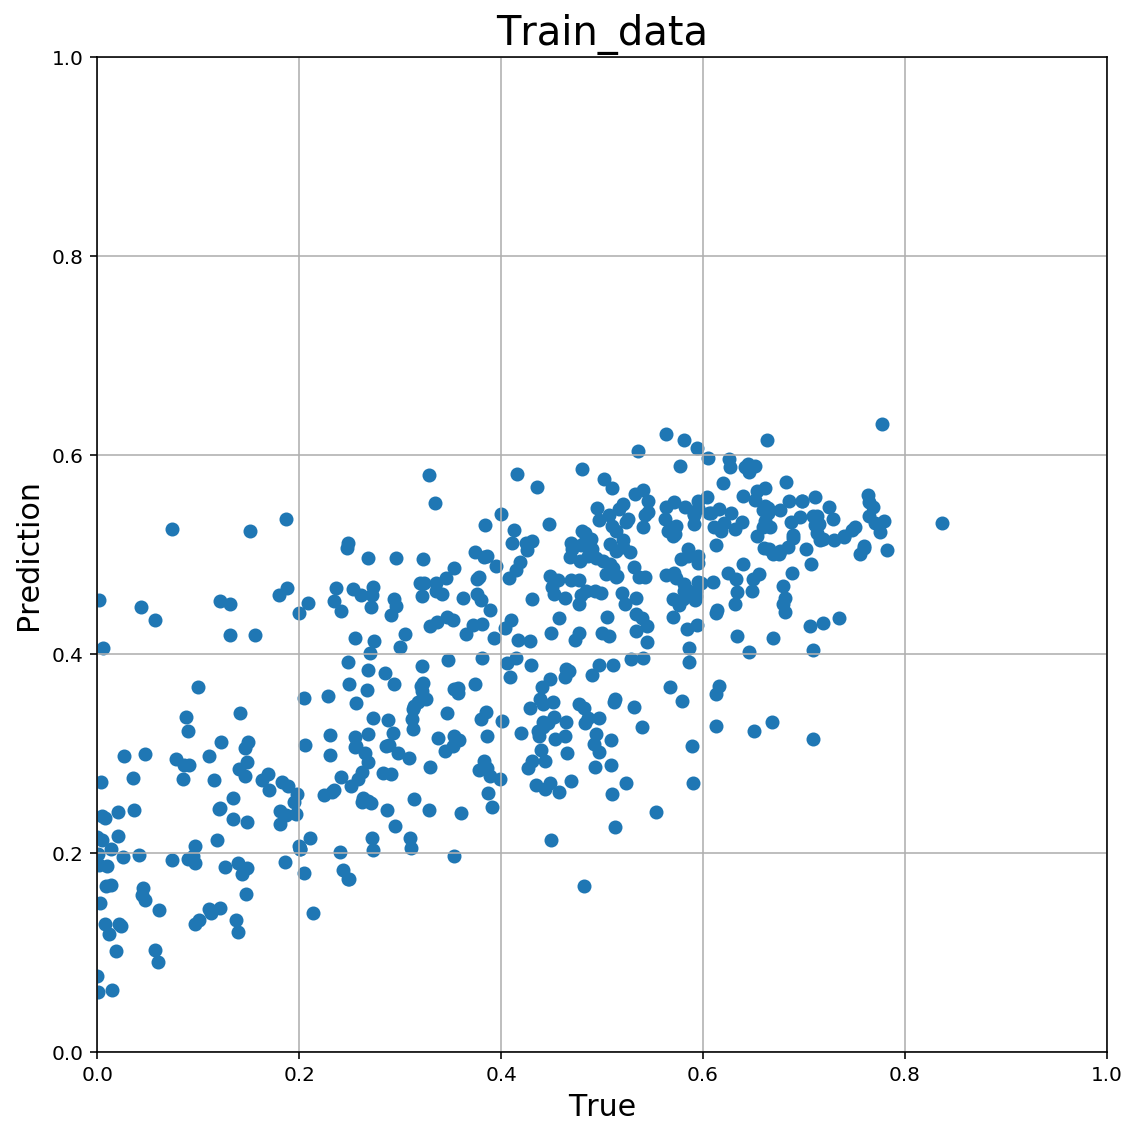

In [26]:
indel_predict = test_prediction
indel_true = test_true

figure = plt.figure(figsize=(8,8))
plt.title("Train_data", fontsize=20)
plt.ylabel('Prediction', fontsize=15)
plt.xlabel('True', fontsize=15)
plt.scatter(x=indel_true, y=indel_predict)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)

plt.tight_layout()

figure.show()

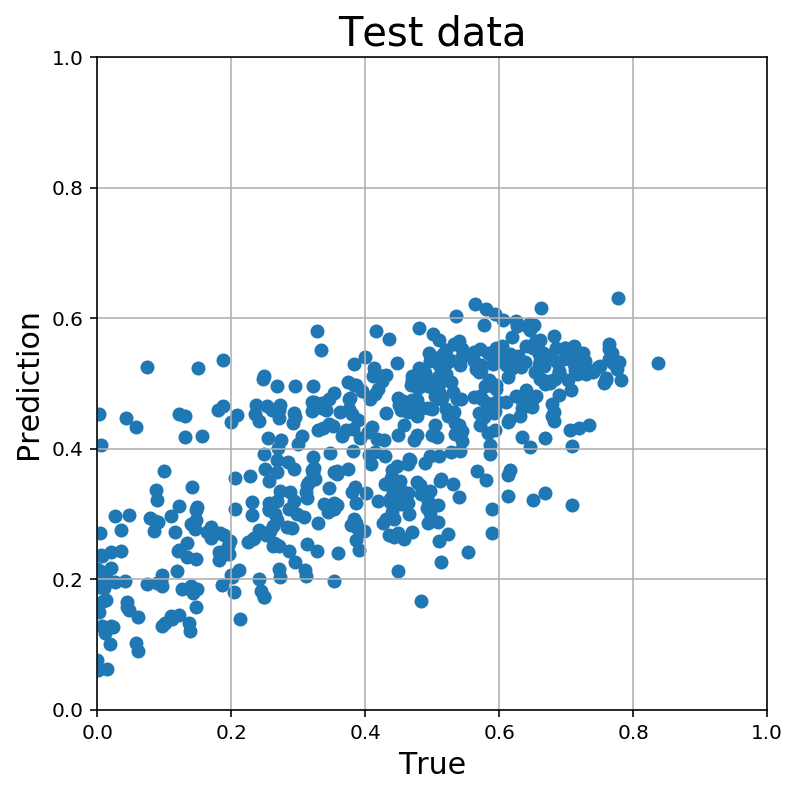

In [15]:
indel_predict = test_prediction
indel_true = test_true

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=indel_true, y=indel_predict)
ax.set_title('Test data', fontsize=20)
ax.set_xlabel('True', fontsize=15)
ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True)
fig.show()

In [16]:
train_prediction = CNNLSTM.regression_model().predict(X_train).reshape(-1,)
train_true = rate_train.reshape(-1,)

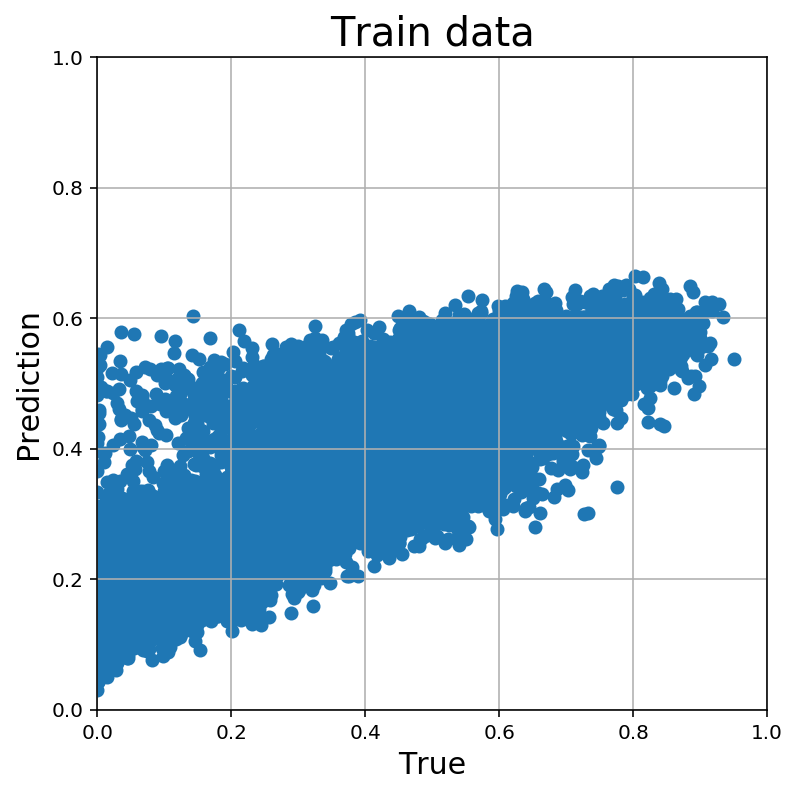

In [17]:
indel_predict = train_prediction
indel_true = train_true

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=indel_true, y=indel_predict)
ax.set_title('Train data', fontsize=20)
ax.set_xlabel('True', fontsize=15)
ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True)
fig.show()

In [18]:
test_class_prediction = CNNLSTM.classification_model().predict(X_test)
test_class_prediction_label = np.argmax(test_class_prediction, axis=-1)
test_class_true_label = np.argmax(class_test,axis=-1)

test_heatmap_matrix = np.zeros((11,11), dtype=int)
for prediction, true in zip(test_class_prediction_label, test_class_true_label):
    test_heatmap_matrix[prediction][true] += 1
test_heatmap_df = pd.DataFrame(test_heatmap_matrix)

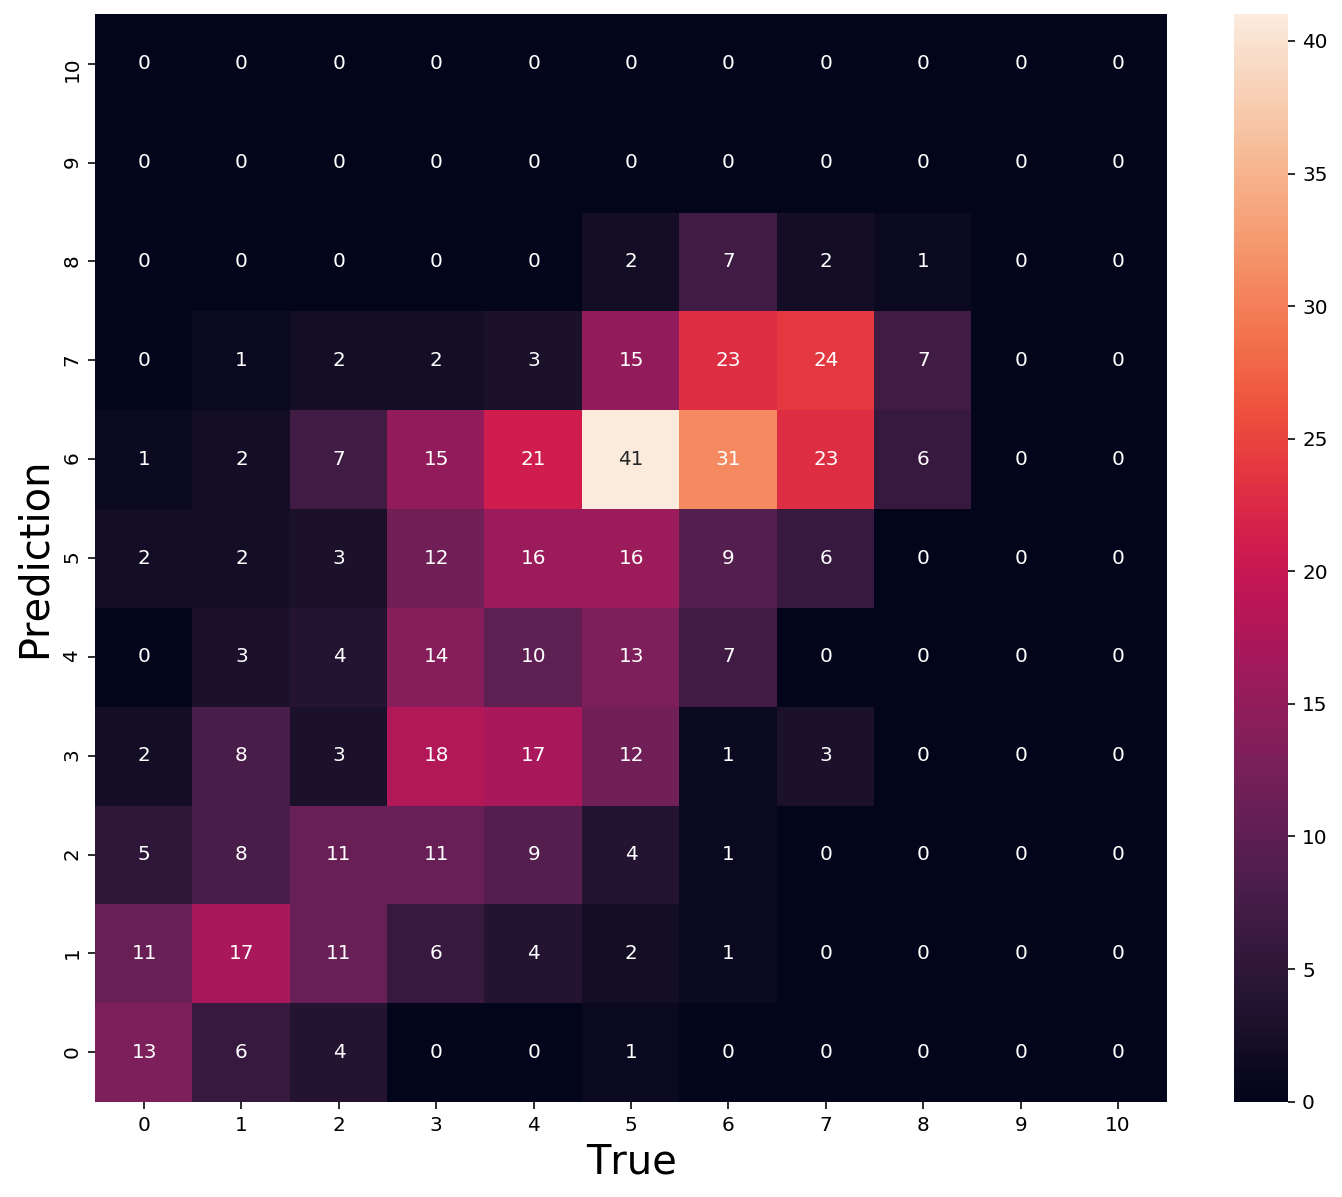

In [19]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(test_heatmap_df,annot=True, fmt='d')
ax.invert_yaxis()
ax.set_xlabel('True',fontsize=20);
ax.set_ylabel('Prediction',fontsize=20);
plt.show()

 # Benchmark

In [20]:
file_name_list = ['Endo_Cas9.csv',
                  'Endo_Cas9_1A.csv',
                  'Endo_Cas9_1B.csv',
                  'Endo_Cas9_2A.csv',
                  'Endo_Cas9_2B.csv',
                  'Endo_Cas9_3A.csv',
                  'Endo_Cas9_3B.csv',
                  'Endo_Cas9_4A.csv',
                  'Endo_Cas9_4B.csv',
                  'Endo_Cas9_5A.csv',
                  'Endo_Cas9_5B.csv']
bench_list = ['Endo_Cas9',
              'Endo_Cas9_1A',
              'Endo_Cas9_1B',
              'Endo_Cas9_2A',
              'Endo_Cas9_2B',
              'Endo_Cas9_3A',
              'Endo_Cas9_3B',
              'Endo_Cas9_4A',
              'Endo_Cas9_4B',
              'Endo_Cas9_5A',
              'Endo_Cas9_5B']

bench_data_endo = {}
for file_name in file_name_list:
    #bench_dict_endo[file_name[:-4]] = pd.read_csv()
    import_data = import_data_preprocessing(train_data_file_name='data/'+file_name)
    bench_data_endo[file_name[:-4]] = import_data(
        sgRNA_column='30 bp target sequence (4 bp + 20 bp Protospacer + PAM + 3 bp)',
        indel_column='Averge indel frequency (%)',
        split_data=0
    )

In [21]:
test_model = CNNLSTM.regression_model()
for data_name in bench_list:
    bench_data_input = bench_data_endo[data_name]['total']['seq']
    bench_data_true_rate = bench_data_endo[data_name]['total']['indel_rate']
    print('Data : {}'.format(data_name))
    pearson, spearman = calc_correlation(
        model=test_model, 
        input_data=bench_data_input, 
        true_data=bench_data_true_rate
    )
    print('\n')

Data : Endo_Cas9
Correlation : 0.5894275271257067
Pearson Correlation : 0.5894275271257066
Spearman Correlation : 0.5945177025963807


Data : Endo_Cas9_1A
Correlation : 0.6369127616763373
Pearson Correlation : 0.636912761676337
Spearman Correlation : 0.7049683966659113


Data : Endo_Cas9_1B
Correlation : 0.5534363161044584
Pearson Correlation : 0.5534363161044584
Spearman Correlation : 0.5181184054795901


Data : Endo_Cas9_2A
Correlation : 0.6481867584254647
Pearson Correlation : 0.6481867584254647
Spearman Correlation : 0.7004356475535746


Data : Endo_Cas9_2B
Correlation : 0.497922295529855
Pearson Correlation : 0.49792229552985484
Spearman Correlation : 0.5072398076099822


Data : Endo_Cas9_3A
Correlation : 0.49809202292054
Pearson Correlation : 0.49809202292053995
Spearman Correlation : 0.4514366296492156


Data : Endo_Cas9_3B
Correlation : 0.6383076114346611
Pearson Correlation : 0.6383076114346609
Spearman Correlation : 0.7191710105512327


Data : Endo_Cas9_4A
Correlation : 0.631